## Import libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# For data modeling
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

## Functions

In [14]:
def evaluate_classification(y_true, y_pred):
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    }

#Function to get metric
def get_metrics_as_dataframe(model_name, metrics_dict):
    model_name = model_name  # Replace with your model's name
    accuracy = metrics_dict['Accuracy']
    precision = metrics_dict['Precision']
    recall = metrics_dict['Recall']
    f1 = metrics_dict['F1 Score']
    
    table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1 Score': [f1],
    })

    return table

class_names = ['0', '1', '2']

def plot_confusion_matrix(true_labels, predicted_labels, class_names):
    # Calculate the confusion matrix
    confusion = confusion_matrix(true_labels, predicted_labels)

    # Calculate row-wise sums (total predictions for each class)
    row_sums = confusion.sum(axis=1)

    # Create a larger heatmap using Seaborn
    plt.figure(figsize=(10, 8))

    # Create the heatmap
    heatmap = sns.heatmap(confusion / row_sums[:, np.newaxis], annot=True, fmt=".1%", cmap='Blues', cbar=False)

    # Customize the plot
    plt.xlabel('Predicted', fontsize=14)  # You can adjust font size
    plt.ylabel('True', fontsize=14)       # You can adjust font size

    # Add class names as tick labels for both axes, centered between the boxes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks + 0.5, class_names, rotation=0)  # Adjusted to center labels
    plt.yticks(tick_marks + 0.5, class_names, rotation=0)   # Adjusted to center labels

    plt.title('Confusion Matrix (in Percentage)', fontsize=16)  # You can adjust font size

    # Show the plot
    plt.show()

def plot_feature_importance(model, X_train):
 
    # Retrieve feature importance scores
    feature_importance = model.feature_importances_

    # Get the names of features
    feature_names = X_train.columns

    # Create a DataFrame with feature names and their importance scores
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Sort the features by importance in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
    plt.title(f'{model.__class__.__name__} - Feature Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.show()

In [15]:
df = pd.read_csv('./cleaned-train.csv')


In [16]:
df.head()

,age,occupation,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,payment_of_min_amount,installment_per_month,amount_invested_monthly,payment_behavior,monthly_balance,credit_score
0,23,Scientist,19114.12,3,4,3,3,809.98,26.82,22.1,No,49.57,80.42,High_spent_Small_value_payments,312.49,2
1,23,Scientist,19114.12,3,4,3,5,809.98,31.38,22.4,No,49.57,199.46,Low_spent_Small_value_payments,223.45,2
2,23,Scientist,19114.12,3,4,3,6,809.98,24.80,22.5,No,49.57,41.42,High_spent_Medium_value_payments,341.49,2
3,23,Scientist,19114.12,3,4,3,3,809.98,22.54,22.7,No,49.57,178.34,Low_spent_Small_value_payments,244.57,2
4,28,Teacher,34847.84,2,4,6,7,605.03,38.55,26.8,No,18.82,40.39,High_spent_Large_value_payments,484.59,2


In [17]:
df.dtypes

age                          int64
occupation                  object
annual_income              float64
num_bank_acc                 int64
num_credit_card              int64
interest_rate                int64
delay_from_due_date          int64
outstanding_debt           float64
credit_util_ratio          float64
credit_history_age         float64
payment_of_min_amount       object
installment_per_month      float64
amount_invested_monthly    float64
payment_behavior            object
monthly_balance            float64
credit_score                 int64
dtype: object

## EDA before modelling

### Distribution of Age

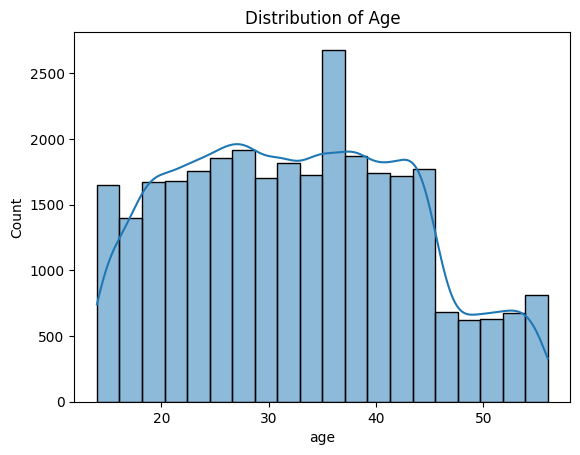

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of numerical features
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Distribution of Age')
plt.show()




### Explore Credit Score Distribution by Occupation

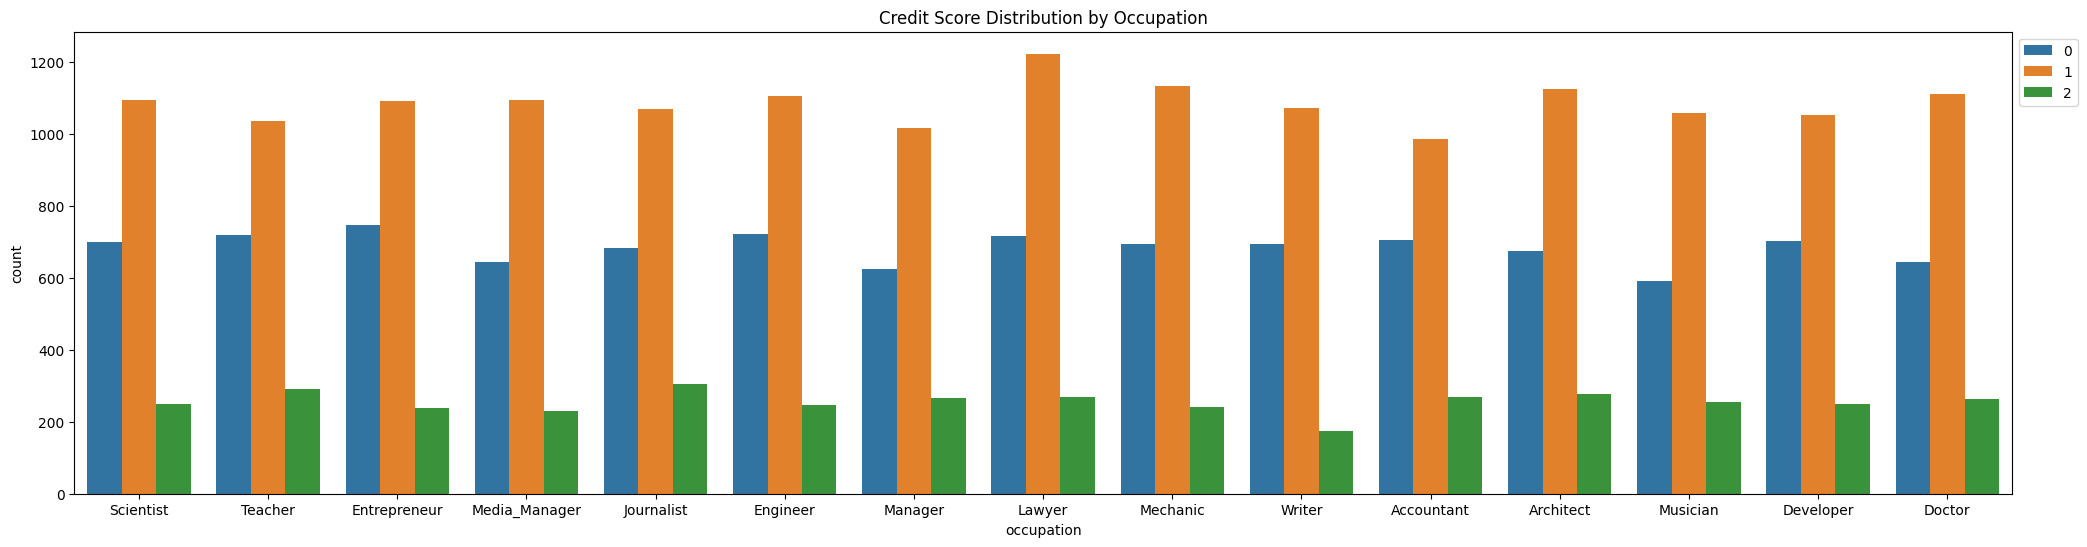

In [19]:
plt.figure(figsize=(25, 6))  # Adjust the width as needed
sns.countplot(x='occupation', hue='credit_score', data=df)
plt.title('Credit Score Distribution by Occupation')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


### Explore credit Score distribution by payment_of_min_amount

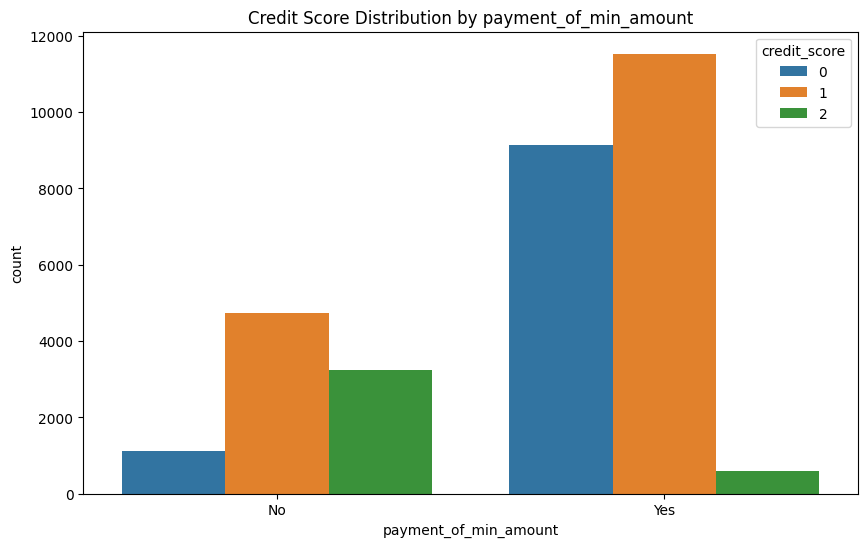

In [20]:
plt.figure(figsize=(10, 6))  # Adjust the width as needed
sns.countplot(x='payment_of_min_amount', hue='credit_score', data=df)
plt.title('Credit Score Distribution by payment_of_min_amount')
plt.show()


### Explore Credit Score Distribution by Payment Behavior

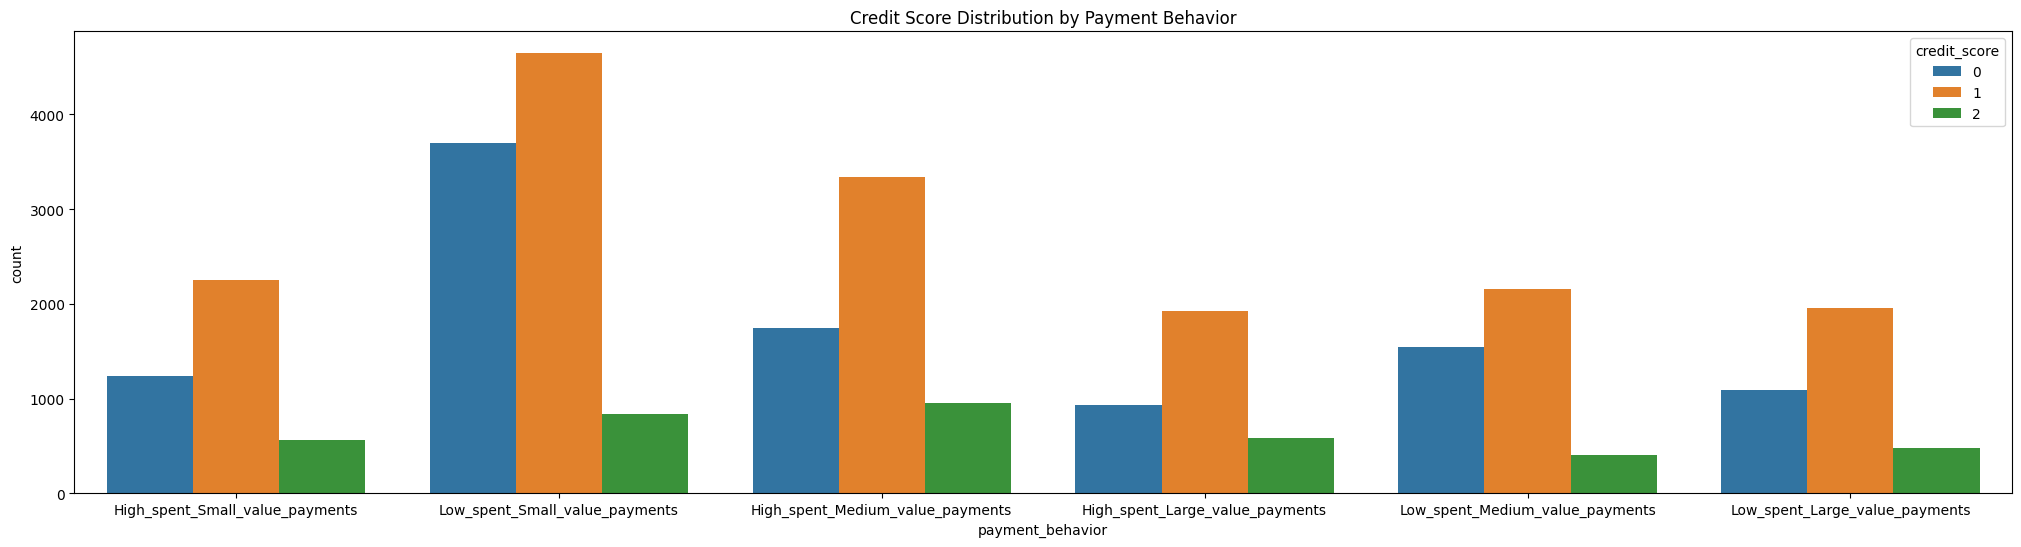

In [21]:
plt.figure(figsize=(25, 6))  # Adjust the width as needed
sns.countplot(x='payment_behavior', hue='credit_score', data=df)
plt.title('Credit Score Distribution by Payment Behavior')
plt.show()


### Explore target variable distribution


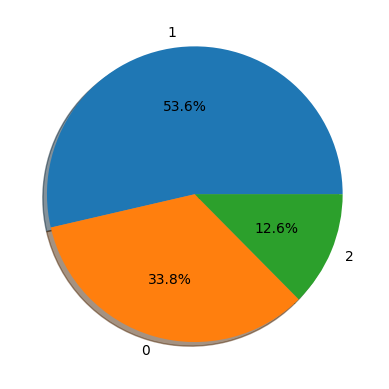

In [22]:
# Explore data balance (0 = poor, 1 = Standard, 2 = Good)
label = df['credit_score'].value_counts().index
label_count = df['credit_score'].value_counts().values
plt.pie(data=df, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1)
plt.show()

### Relationships between features and target variable 

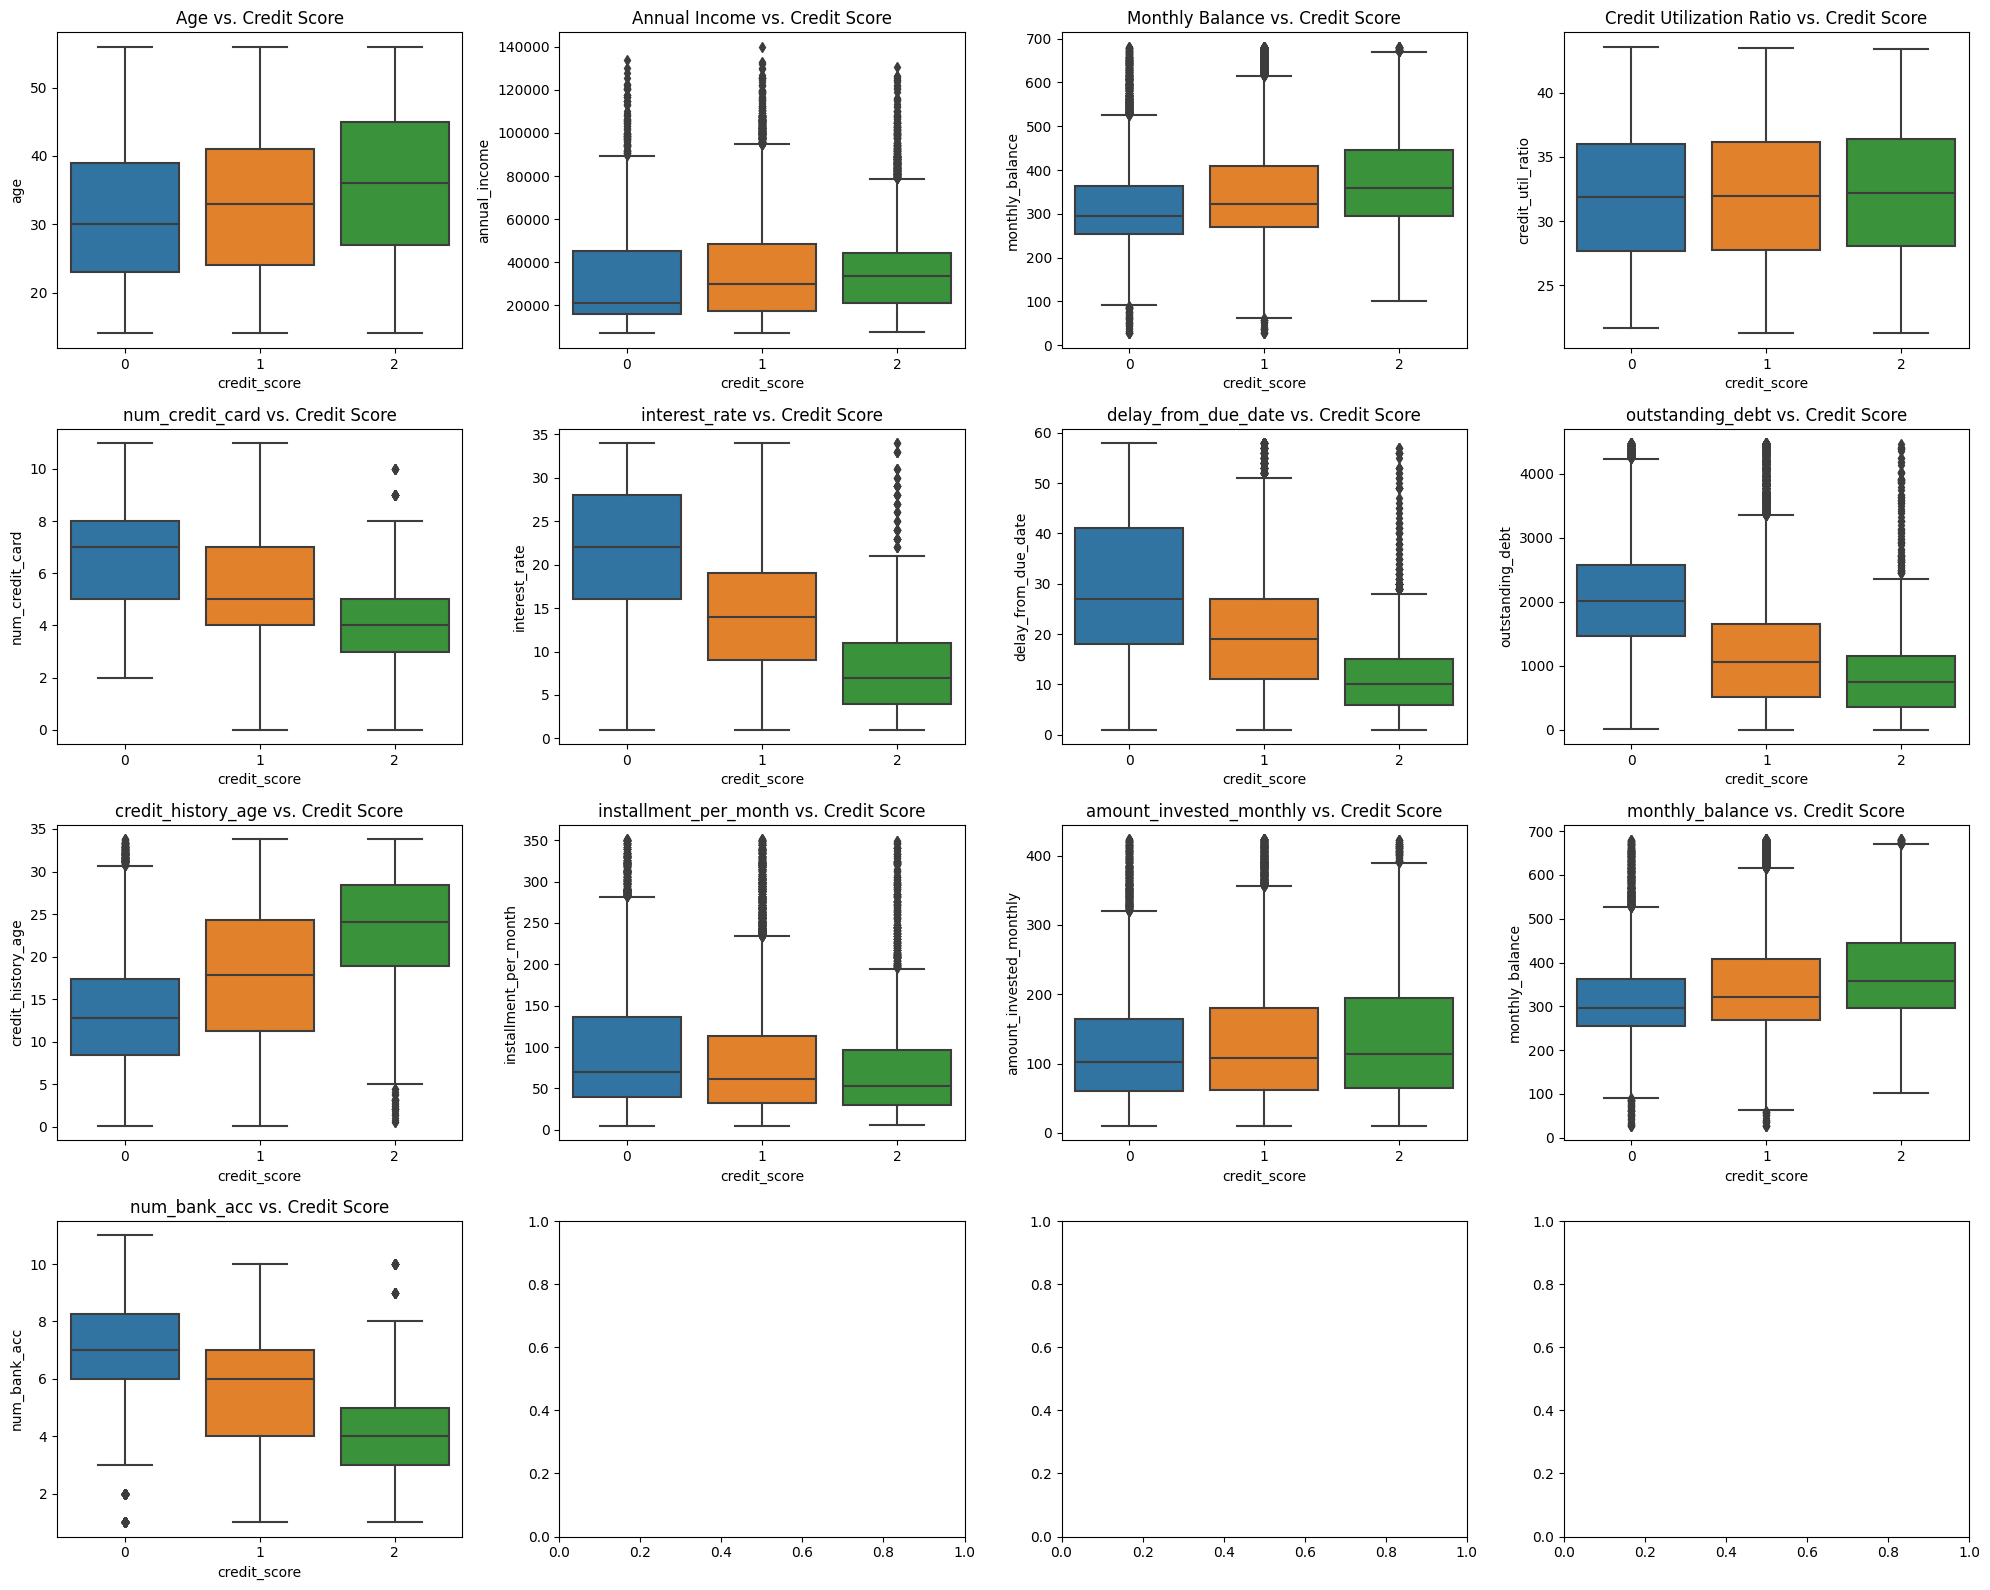

In [23]:
# Set up subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))

# Plot Age vs. Credit Score
sns.boxplot(x='credit_score', y='age', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age vs. Credit Score')

# Plot Annual Income vs. Credit Score
sns.boxplot(x='credit_score', y='annual_income', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Annual Income vs. Credit Score')

# Plot Monthly Balance vs. Credit Score
sns.boxplot(x='credit_score', y='monthly_balance', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Monthly Balance vs. Credit Score')

# Plot Credit Utilization Ratio vs. Credit Score
sns.boxplot(x='credit_score', y='credit_util_ratio', data=df, ax=axes[0, 3])
axes[0, 3].set_title('Credit Utilization Ratio vs. Credit Score')

# Plot num_credit_card vs. Credit Score
sns.boxplot(x='credit_score', y='num_credit_card', data=df, ax=axes[1, 0])
axes[1, 0].set_title('num_credit_card vs. Credit Score')

# Plot interest_rate vs. Credit Score
sns.boxplot(x='credit_score', y='interest_rate', data=df, ax=axes[1, 1])
axes[1, 1].set_title('interest_rate vs. Credit Score')

# Plot delay_from_due_date vs. Credit Score
sns.boxplot(x='credit_score', y='delay_from_due_date', data=df, ax=axes[1, 2])
axes[1, 2].set_title('delay_from_due_date vs. Credit Score')

# Plot outstanding_debt vs. Credit Score
sns.boxplot(x='credit_score', y='outstanding_debt', data=df, ax=axes[1, 3])
axes[1, 3].set_title('outstanding_debt vs. Credit Score')

# Plot credit_history_age vs. Credit Score
sns.boxplot(x='credit_score', y='credit_history_age', data=df, ax=axes[2, 0])
axes[2, 0].set_title('credit_history_age vs. Credit Score')

# Plot installment_per_month vs. Credit Score
sns.boxplot(x='credit_score', y='installment_per_month', data=df, ax=axes[2, 1])
axes[2, 1].set_title('installment_per_month vs. Credit Score')

# Plot amount_invested_monthly vs. Credit Score
sns.boxplot(x='credit_score', y='amount_invested_monthly', data=df, ax=axes[2, 2])
axes[2, 2].set_title('amount_invested_monthly vs. Credit Score')

# Plot monthly_balance vs. Credit Score
sns.boxplot(x='credit_score', y='monthly_balance', data=df, ax=axes[2, 3])
axes[2, 3].set_title('monthly_balance vs. Credit Score')

# Plot num_bank_acc vs. Credit Score
sns.boxplot(x='credit_score', y='num_bank_acc', data=df, ax=axes[3, 0])
axes[3, 0].set_title('num_bank_acc vs. Credit Score')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Heatmap for feature correlation analysis

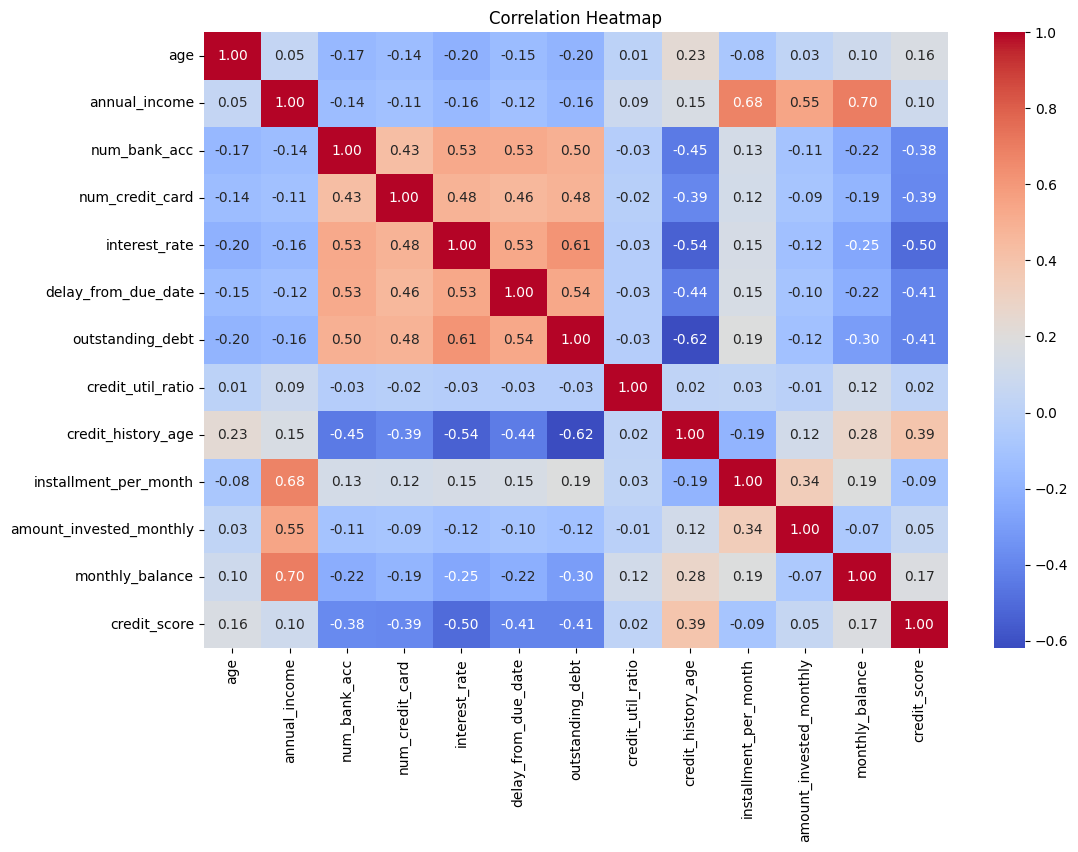

In [24]:
# Select only numeric columns for correlation matrix
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

## Data preprocessing 

In [25]:
df.head()

,age,occupation,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,payment_of_min_amount,installment_per_month,amount_invested_monthly,payment_behavior,monthly_balance,credit_score
0,23,Scientist,19114.12,3,4,3,3,809.98,26.82,22.1,No,49.57,80.42,High_spent_Small_value_payments,312.49,2
1,23,Scientist,19114.12,3,4,3,5,809.98,31.38,22.4,No,49.57,199.46,Low_spent_Small_value_payments,223.45,2
2,23,Scientist,19114.12,3,4,3,6,809.98,24.80,22.5,No,49.57,41.42,High_spent_Medium_value_payments,341.49,2
3,23,Scientist,19114.12,3,4,3,3,809.98,22.54,22.7,No,49.57,178.34,Low_spent_Small_value_payments,244.57,2
4,28,Teacher,34847.84,2,4,6,7,605.03,38.55,26.8,No,18.82,40.39,High_spent_Large_value_payments,484.59,2


In [26]:
# Selecting categorical features
categorical_features = ['occupation', 'payment_of_min_amount', 'payment_behavior']

# Applying one-hot encoding
df = pd.get_dummies(df, columns=categorical_features, drop_first=True)

In [27]:
df.head()

,age,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,installment_per_month,...,occupation_Musician,occupation_Scientist,occupation_Teacher,occupation_Writer,payment_of_min_amount_Yes,payment_behavior_High_spent_Medium_value_payments,payment_behavior_High_spent_Small_value_payments,payment_behavior_Low_spent_Large_value_payments,payment_behavior_Low_spent_Medium_value_payments,payment_behavior_Low_spent_Small_value_payments
0,23,19114.12,3,4,3,3,809.98,26.82,22.1,49.57,...,False,True,False,False,False,False,True,False,False,False
1,23,19114.12,3,4,3,5,809.98,31.38,22.4,49.57,...,False,True,False,False,False,False,False,False,False,True
2,23,19114.12,3,4,3,6,809.98,24.80,22.5,49.57,...,False,True,False,False,False,True,False,False,False,False
3,23,19114.12,3,4,3,3,809.98,22.54,22.7,49.57,...,False,True,False,False,False,False,False,False,False,True
4,28,34847.84,2,4,6,7,605.03,38.55,26.8,18.82,...,False,False,True,False,False,False,False,False,False,False


## Modelling

In [28]:
X = df.drop(['credit_score'], axis=1)
y = df['credit_score']

In [29]:
X.head()

,age,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,installment_per_month,...,occupation_Musician,occupation_Scientist,occupation_Teacher,occupation_Writer,payment_of_min_amount_Yes,payment_behavior_High_spent_Medium_value_payments,payment_behavior_High_spent_Small_value_payments,payment_behavior_Low_spent_Large_value_payments,payment_behavior_Low_spent_Medium_value_payments,payment_behavior_Low_spent_Small_value_payments
0,23,19114.12,3,4,3,3,809.98,26.82,22.1,49.57,...,False,True,False,False,False,False,True,False,False,False
1,23,19114.12,3,4,3,5,809.98,31.38,22.4,49.57,...,False,True,False,False,False,False,False,False,False,True
2,23,19114.12,3,4,3,6,809.98,24.80,22.5,49.57,...,False,True,False,False,False,True,False,False,False,False
3,23,19114.12,3,4,3,3,809.98,22.54,22.7,49.57,...,False,True,False,False,False,False,False,False,False,True
4,28,34847.84,2,4,6,7,605.03,38.55,26.8,18.82,...,False,False,True,False,False,False,False,False,False,False


In [30]:
y.head()

0    2
1    2
2    2
3    2
4    2
Name: credit_score, dtype: int64

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0) ##using stratify=y since it is imbalance

In [32]:
X_train.shape, X_test.shape

((24281, 32), (6071, 32))

## Model 1 : Using Decision Tree Classifier 

In [162]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

In [163]:
## Predict on test
y_pred = dtree.predict(X_test)

In [164]:
## Evaluate metrics of the model
dtree_metric = evaluate_classification(y_test, y_pred)
dtree_metric

{'Accuracy': 0.7074617031790479,
 'Precision': 0.706946975403388,
 'Recall': 0.7074617031790479,
 'F1 Score': 0.7071826162679244,
 'Confusion Matrix': array([[1434,  578,   40],
        [ 571, 2420,  264],
        [  36,  287,  441]], dtype=int64)}

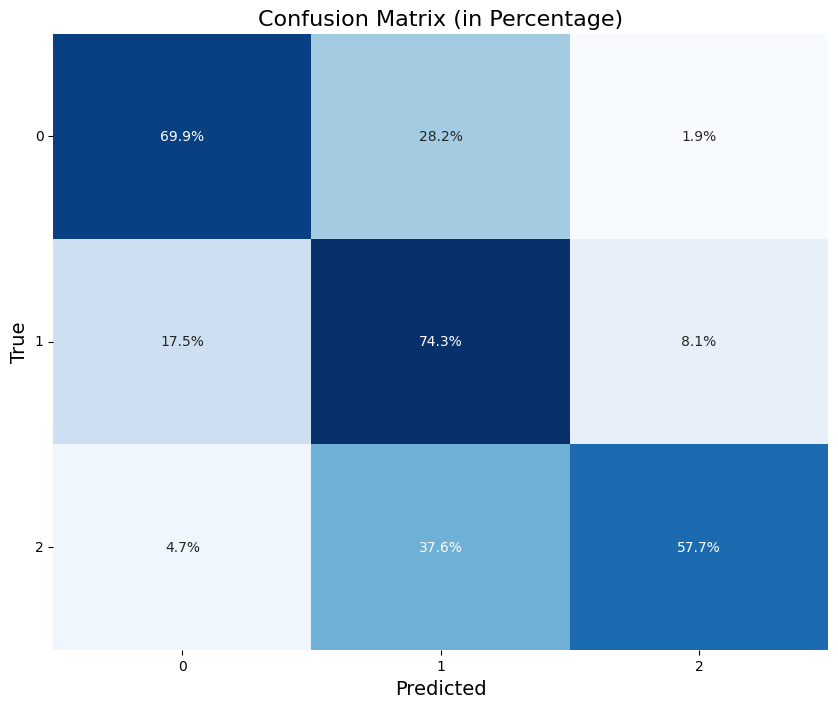

In [165]:
## Plot confusion matrix
import numpy as np
plot_confusion_matrix(y_test, y_pred, class_names=class_names)

In [166]:
## Return as table
dtree_table = get_metrics_as_dataframe("Decision Tree Classifier", dtree_metric)
dtree_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Decision Tree Classifier,0.707462,0.706947,0.707462,0.707183


## Model 2: Random Forest Classifier

In [167]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_clf = rf.fit(X_train, y_train)

In [168]:
rf_y_pred = rf.predict(X_test)

In [169]:
## Evaluate metrics of the model
rf_metrics = evaluate_classification(y_test, rf_y_pred)
rf_metrics

{'Accuracy': 0.7784549497611596,
 'Precision': 0.7780757522877405,
 'Recall': 0.7784549497611596,
 'F1 Score': 0.7765922041615304,
 'Confusion Matrix': array([[1658,  382,   12],
        [ 505, 2621,  129],
        [   6,  311,  447]], dtype=int64)}

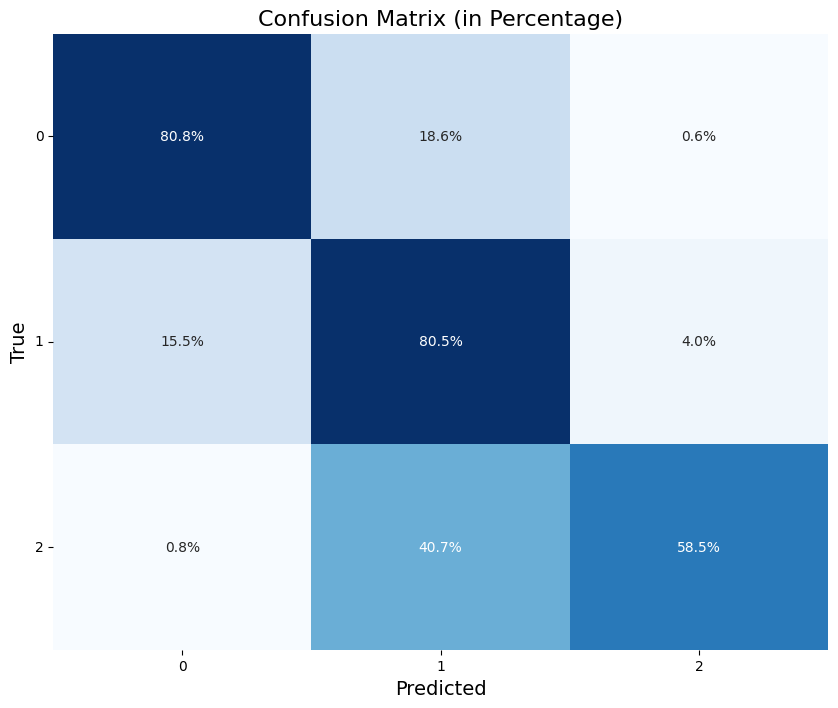

In [170]:
## Confusion Matrix
plot_confusion_matrix(y_test, rf_y_pred, class_names=class_names)

In [171]:
## Return as table
rf_table = get_metrics_as_dataframe("Random Forest Classifier", rf_metrics)
rf_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classifier,0.778455,0.778076,0.778455,0.776592


## Model 3: XGBoost Classifier

In [172]:
from xgboost import XGBClassifier
from xgboost import plot_importance
# Instantiate the XGBClassifier
xgb_classifier = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

# Train the model
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=3,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [173]:
# Make predictions
xgb_y_pred = xgb_classifier.predict(X_test)

In [174]:
## Evaluate metrics of the model
xgb_metrics = evaluate_classification(y_test, xgb_y_pred)
xgb_metrics

{'Accuracy': 0.7585241311151375,
 'Precision': 0.7574938730760353,
 'Recall': 0.7585241311151375,
 'F1 Score': 0.7569121666809163,
 'Confusion Matrix': array([[1604,  420,   28],
        [ 541, 2563,  151],
        [  14,  312,  438]], dtype=int64)}

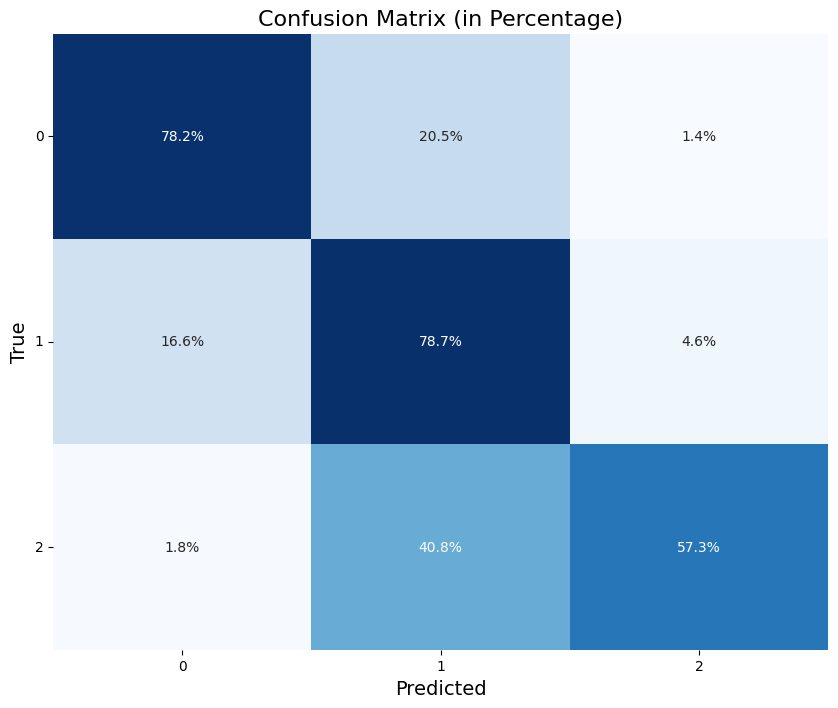

In [175]:
## Confusion Matrix
plot_confusion_matrix(y_test, xgb_y_pred, class_names=class_names)

In [176]:
## Return as table
xgb_table = get_metrics_as_dataframe("XGBoost Classifier", xgb_metrics)
xgb_table

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost Classifier,0.758524,0.757494,0.758524,0.756912


## Preliminary model training results summary

In [177]:
#Comparison between pretrained models 
combined_tables = pd.concat([dtree_table, rf_table, xgb_table], axis=0)
combined_tables = combined_tables.reset_index(drop=True)
combined_tables.sort_values(by='Accuracy', ascending=False)


,Model,Accuracy,Precision,Recall,F1 Score
1,Random Forest Classifier,0.778455,0.778076,0.778455,0.776592
2,XGBoost Classifier,0.758524,0.757494,0.758524,0.756912
0,Decision Tree Classifier,0.707462,0.706947,0.707462,0.707183


# Fine-tuning model using randomized search and feature selection
* Future model improvements, use gridsearch to find best parameters

### Randomized search (xgb classifier)

In [39]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Define the parameter distribution for XGBoost
param_dist = {
    'n_estimators': randint(100, 1000),  # Adjust the range based on your problem
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': randint(1, 20),
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 1, 2, 3, 4],
    'min_child_weight': [1, 2, 3, 4, 5],
}

# Create a RandomizedSearchCV object for XGBoost
xgb_random = RandomizedSearchCV(
    XGBClassifier(),
    param_distributions=param_dist,
    n_iter=20,  # Adjust the number of iterations based on computational resources
    cv=5,  # Adjust the number of cross-validation folds
    scoring='accuracy',  # Use an appropriate scoring metric for your problem
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data
#xgb_random.fit(X_train, y_train)

# Get the best parameters
best_params = xgb_random.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'colsample_bytree': 0.6, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 16, 'min_child_weight': 4, 'n_estimators': 238, 'subsample': 1.0}


In [185]:
best_xgb = xgb_random.best_estimator_
best_xgb


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=238, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred_xgb_random = best_xgb.predict(X_test)

In [42]:
## Evaluate metrics of the model
xgb_random_metrics = evaluate_classification(y_test, y_pred_xgb_random)
xgb_random_metrics

{'Accuracy': 0.7827376050074123,
 'Precision': 0.7822618520509519,
 'Recall': 0.7827376050074123,
 'F1 Score': 0.7812656312664197,
 'Confusion Matrix': array([[1656,  380,   16],
        [ 491, 2632,  132],
        [   9,  291,  464]], dtype=int64)}

In [186]:
## Return as table
xgb_random_table = get_metrics_as_dataframe("XGBoost Classifier (randomized search)", xgb_random_metrics)
xgb_random_table

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost Classifier (randomized search),0.782738,0.782262,0.782738,0.781266


## Drop less important features and retrain the model

In [ ]:
# Retrieve feature importance scores
feature_importance = best_xgb.feature_importances_

# Get the names of features
feature_names = X_train.columns  # Replace X_train with your feature matrix

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [69]:
# Set a threshold for feature importance
importance_threshold = 0.02

# Identify low-importance features
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature']

print(low_importance_features)

8                                    credit_history_age
31      payment_behavior_Low_spent_Small_value_payments
1                                         annual_income
9                                 installment_per_month
13                                 occupation_Developer
21                             occupation_Media_Manager
22                                  occupation_Musician
24                                   occupation_Teacher
19                                   occupation_Manager
14                                    occupation_Doctor
0                                                   age
20                                  occupation_Mechanic
12                                 occupation_Architect
16                              occupation_Entrepreneur
25                                    occupation_Writer
18                                    occupation_Lawyer
17                                occupation_Journalist
23                                 occupation_Sc

In [70]:
# Drop low-importance features from your dataset
X_train_filtered = X_train.drop(low_importance_features, axis=1)
X_test_filtered = X_test.drop(low_importance_features, axis=1)  # If you have a separate test set

In [77]:
X_train.columns

Index(['age', 'annual_income', 'num_bank_acc', 'num_credit_card',
       'interest_rate', 'delay_from_due_date', 'outstanding_debt',
       'credit_util_ratio', 'credit_history_age', 'installment_per_month',
       'amount_invested_monthly', 'monthly_balance', 'occupation_Architect',
       'occupation_Developer', 'occupation_Doctor', 'occupation_Engineer',
       'occupation_Entrepreneur', 'occupation_Journalist', 'occupation_Lawyer',
       'occupation_Manager', 'occupation_Mechanic', 'occupation_Media_Manager',
       'occupation_Musician', 'occupation_Scientist', 'occupation_Teacher',
       'occupation_Writer', 'payment_of_min_amount_Yes',
       'payment_behavior_High_spent_Medium_value_payments',
       'payment_behavior_High_spent_Small_value_payments',
       'payment_behavior_Low_spent_Large_value_payments',
       'payment_behavior_Low_spent_Medium_value_payments',
       'payment_behavior_Low_spent_Small_value_payments'],
      dtype='object')

In [71]:
X_train_filtered.head()

,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,payment_of_min_amount_Yes
22559,7,6,10,28,37.20,True
24507,7,3,10,18,453.73,False
13851,3,4,14,25,1330.70,True
15188,8,3,34,19,2391.98,True
15399,6,8,22,32,3517.04,True


In [75]:
X_test_filtered.head()

,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,payment_of_min_amount_Yes
3193,8,7,12,23,13.24,False
2930,6,5,29,56,1747.01,True
7528,6,8,15,25,2750.88,True
9586,9,6,22,48,3917.82,True
22317,4,5,19,18,335.04,True


In [72]:
# Retrain your model on the filtered dataset
best_xgb.fit(X_train_filtered, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=16, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              n_estimators=238, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [73]:
y_pred_xgb_drop_random = best_xgb.predict(X_test_filtered)

In [74]:
## Evaluate metrics of the model
xgb_random_2_metrics = evaluate_classification(y_test, y_pred_xgb_drop_random)
xgb_random_2_metrics

{'Accuracy': 0.7820787349695273,
 'Precision': 0.7814730346512755,
 'Recall': 0.7820787349695273,
 'F1 Score': 0.7805468262085509,
 'Confusion Matrix': array([[1666,  371,   15],
        [ 494, 2622,  139],
        [  11,  293,  460]], dtype=int64)}

In [187]:
## Return as table
xgb_random_2_table = get_metrics_as_dataframe("XGBoost Classifier (randomized search with dropped features)", xgb_random_2_metrics)
xgb_random_2_table

,Model,Accuracy,Precision,Recall,F1 Score
0,XGBoost Classifier (randomized search with dro...,0.782079,0.781473,0.782079,0.780547


### Randomized Search (rf_classifier)

In [59]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'bootstrap': [True, False]
}

# Create a RandomizedSearchCV object
rf_random = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_dist,
    n_iter=20,  # Adjust the number of iterations based on computational resources
    cv=5,  # Adjust the number of cross-validation folds
    scoring='accuracy',  # Use an appropriate scoring metric for your problem
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data
#rf_random.fit(X_train, y_train)

# Get the best parameters
best_params = rf_random.best_params_
print("Best Hyperparameters:", best_params)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 500}


In [60]:
best_model = rf_random.best_estimator_
y_pred_rf_random = best_model.predict(X_test)

In [61]:
## Evaluate metrics of the model
rf_random_metrics = evaluate_classification(y_test, y_pred_rf_random)
rf_random_metrics

{'Accuracy': 0.7792785373085159,
 'Precision': 0.7789390035221282,
 'Recall': 0.7792785373085159,
 'F1 Score': 0.7776455682445145,
 'Confusion Matrix': array([[1653,  387,   12],
        [ 502, 2622,  131],
        [   7,  301,  456]], dtype=int64)}

In [208]:
## Return as table
rf_random_table = get_metrics_as_dataframe("Random Forest Classifier (randomized search)", rf_random_metrics)
rf_random_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classifier (randomized search),0.779279,0.778939,0.779279,0.777646


### Check feature importance

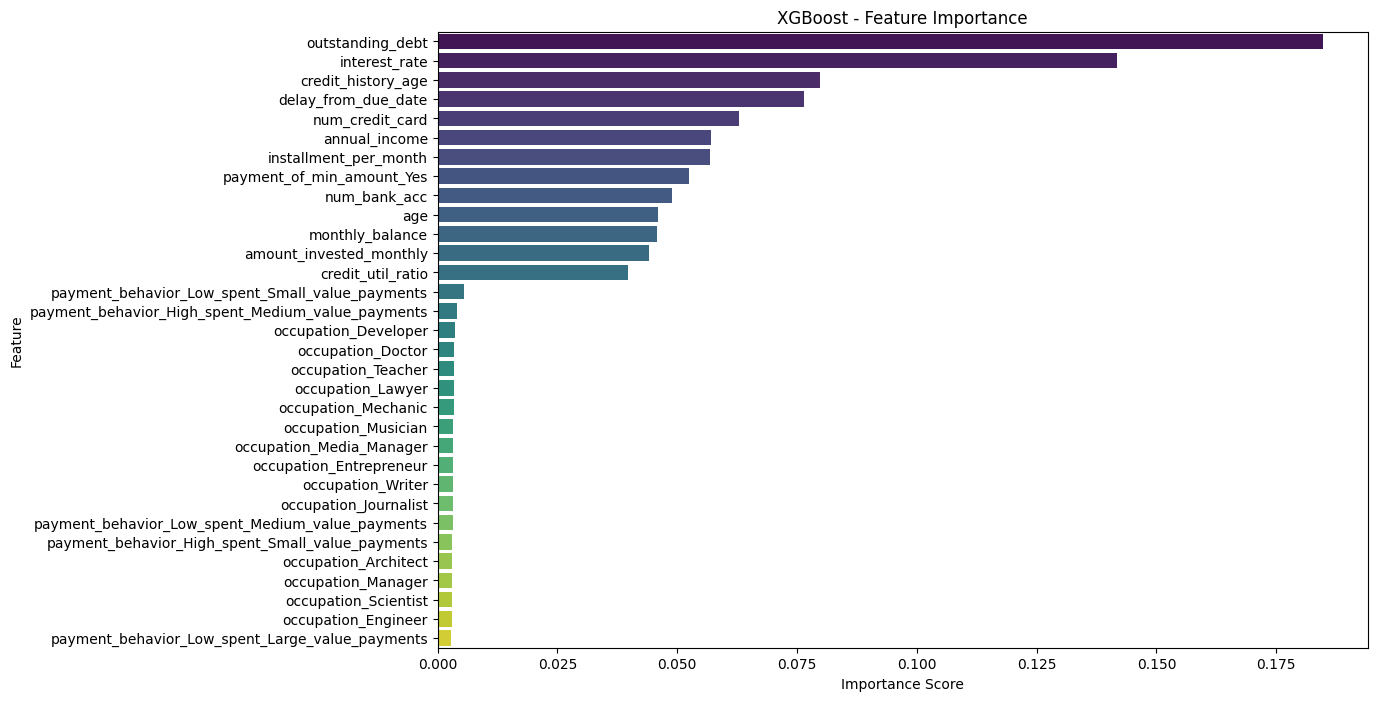

In [85]:
# Retrieve feature importance scores
feature_importance = best_model.feature_importances_

# Get the names of features
feature_names = X_train.columns  # Replace X_train with your feature matrix

# Create a DataFrame with feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})

# Sort the features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('XGBoost - Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

### Dropping features and retraining model

In [86]:
# Set a threshold for feature importance
importance_threshold = 0.03

# Identify low-importance features
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < importance_threshold]['Feature']

print(low_importance_features)

31      payment_behavior_Low_spent_Small_value_payments
27    payment_behavior_High_spent_Medium_value_payments
13                                 occupation_Developer
14                                    occupation_Doctor
24                                   occupation_Teacher
18                                    occupation_Lawyer
20                                  occupation_Mechanic
22                                  occupation_Musician
21                             occupation_Media_Manager
16                              occupation_Entrepreneur
25                                    occupation_Writer
17                                occupation_Journalist
30     payment_behavior_Low_spent_Medium_value_payments
28     payment_behavior_High_spent_Small_value_payments
12                                 occupation_Architect
19                                   occupation_Manager
23                                 occupation_Scientist
15                                  occupation_E

In [87]:
# Drop low-importance features from your dataset
X_train_filtered_2 = X_train.drop(low_importance_features, axis=1)
X_test_filtered_2 = X_test.drop(low_importance_features, axis=1)  # If you have a separate test set

In [88]:
X_train_filtered_2.head()

,age,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,installment_per_month,amount_invested_monthly,monthly_balance,payment_of_min_amount_Yes
22559,15,28730.26,7,6,10,28,37.20,30.29,32.20,54.04,199.61,269.67,True
24507,48,17950.55,7,3,10,18,453.73,25.56,15.11,27.42,180.22,247.05,False
13851,33,22007.11,3,4,14,25,1330.70,36.38,28.70,45.13,178.21,245.06,True
15188,17,35662.88,8,3,34,19,2391.98,27.74,18.11,60.79,101.34,357.57,True
15399,35,52338.57,6,8,22,32,3517.04,37.16,11.40,150.60,300.76,273.79,True


In [96]:
X_train_filtered_2.columns

Index(['age', 'annual_income', 'num_bank_acc', 'num_credit_card',
       'interest_rate', 'delay_from_due_date', 'outstanding_debt',
       'credit_util_ratio', 'credit_history_age', 'installment_per_month',
       'amount_invested_monthly', 'monthly_balance',
       'payment_of_min_amount_Yes'],
      dtype='object')

In [89]:
# Retrain your model on the filtered dataset
best_model.fit(X_train_filtered_2, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='log2',
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=500)

In [219]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 500}

In [220]:
# Define the hyperparameters
hyperparameters = {
    'bootstrap': False,
    'max_depth': 40,
    'max_features': 'log2',
    'min_samples_leaf': 3,
    'min_samples_split': 4,
    'n_estimators': 500
}

In [225]:
## Retrain model using best params
# Initialize the Random Forest Classifier with the specified hyperparameters
rf_classifier_random_drop = RandomForestClassifier(**hyperparameters)

# Train the model on your training data
rf_classifier_random_drop.fit(X_train_filtered_2, y_train)

RandomForestClassifier(bootstrap=False, max_depth=40, max_features='log2',
                       min_samples_leaf=3, min_samples_split=4,
                       n_estimators=500)

In [226]:
y_pred_rf_random_dropped = rf_classifier_random_drop.predict(X_test_filtered_2)

In [227]:
## Evaluate metrics of the model
rf_random_2_metrics = evaluate_classification(y_test, y_pred_rf_random_dropped)
rf_random_2_metrics

{'Accuracy': 0.78767913029155,
 'Precision': 0.7873461567131955,
 'Recall': 0.78767913029155,
 'F1 Score': 0.7865314654731544,
 'Confusion Matrix': array([[1668,  370,   14],
        [ 486, 2633,  136],
        [   7,  276,  481]], dtype=int64)}

In [228]:
## Return as table
rf_random_2_table = get_metrics_as_dataframe("Random Forest Classifier (RandomSearch with dropped features)", rf_random_2_metrics)
rf_random_2_table

,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest Classifier (RandomSearch with dropped features),0.787679,0.787346,0.787679,0.786531


In [229]:
# Save the model to a file using pickle
with open('./models/rf_classifier_random_drop.pkl', 'wb') as file:
    pickle.dump(best_model, file)

In [230]:
## Load model
# Specify the path to your pickled model file
model_file_path = './models/rf_classifier_random_drop.pkl'

# Open the pickled model file for reading in binary mode (rb)
with open(model_file_path, 'rb') as model_file:
    # Load the model using pickle.load()
    model = pickle.load(model_file)

## Plot Confusion matrix

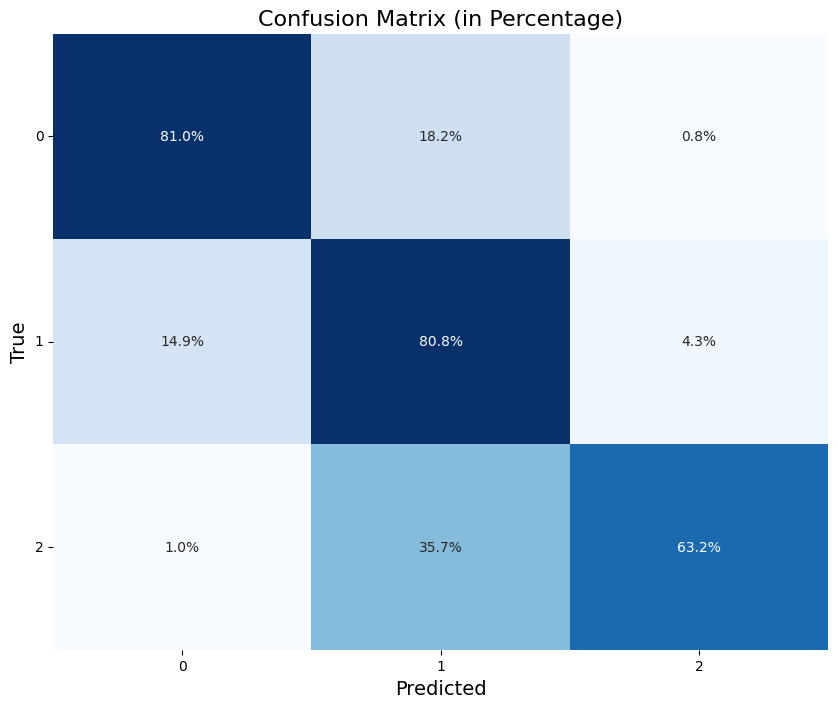

In [46]:
plot_confusion_matrix(y_test, y_pred_rf_random_dropped, class_names=class_names)

## Plot feature importance

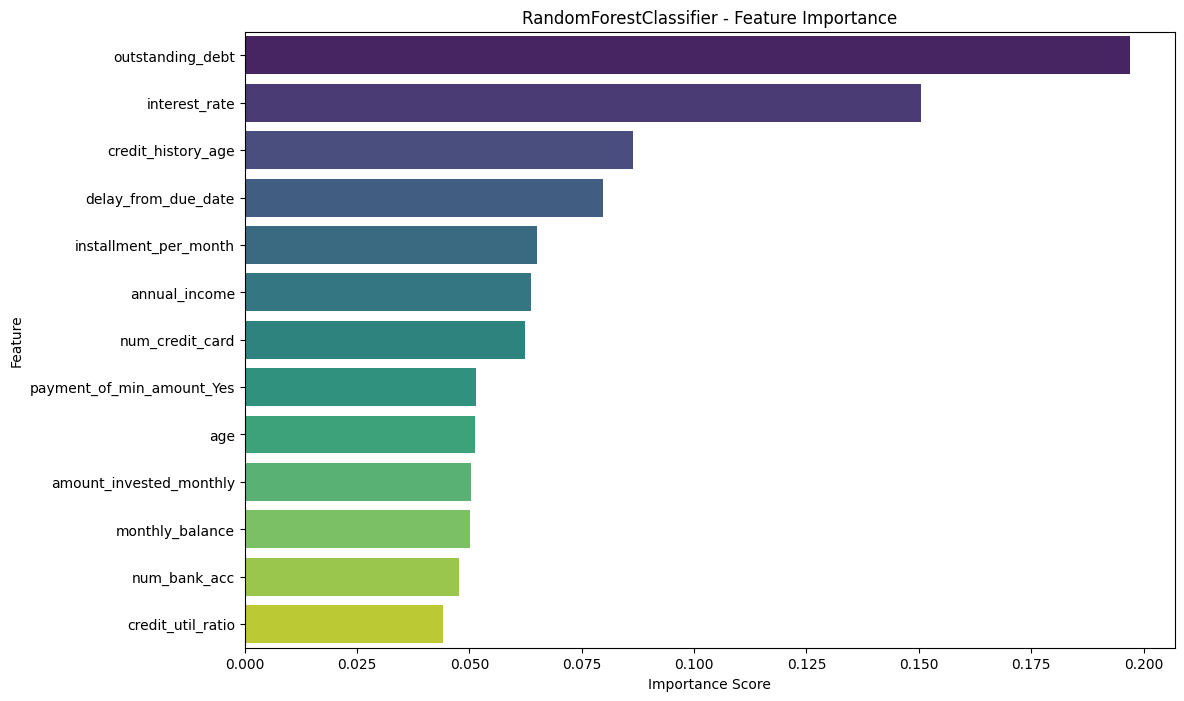

In [231]:
plot_feature_importance(model, X_train_filtered_2)

## Final model selection after hyperparameter tuning and feature selection

In [232]:
# Set the maximum column width to a larger value
pd.set_option('display.max_colwidth', 100)

In [233]:
#Comparison between pretrained models 
combined_tables_2 = pd.concat([xgb_random_table, xgb_random_2_table, rf_random_table, rf_random_2_table], axis=0)
combined_tables_2 = combined_tables_2.reset_index(drop=True)
combined_tables_2.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
3,Random Forest Classifier (RandomSearch with dropped features),0.787679,0.787346,0.787679,0.786531
0,XGBoost Classifier (randomized search),0.782738,0.782262,0.782738,0.781266
1,XGBoost Classifier (randomized search with dropped features),0.782079,0.781473,0.782079,0.780547
2,Random Forest Classifier (randomized search),0.779279,0.778939,0.779279,0.777646


## Inference model on test dataset (unlabeled)

In [99]:
import pandas as pd
test = pd.read_csv('./cleaned-test.csv')

In [100]:
test_cleaned = test.copy()

In [101]:
test_cleaned.head()

,age,occupation,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,payment_of_min_amount,installment_per_month,amount_invested_monthly,payment_behavior,monthly_balance
0,23,Scientist,19114.12,3,4,3,3,809.98,35.03,22.90,No,49.57,236.64,Low_spent_Small_value_payments,186.27
1,24,Scientist,19114.12,3,4,3,3,809.98,33.05,22.10,No,49.57,21.47,High_spent_Medium_value_payments,361.44
2,28,Teacher,34847.84,2,4,6,3,605.03,30.12,27.40,No,18.82,251.63,Low_spent_Large_value_payments,303.36
3,28,Teacher,34847.84,2,4,6,3,605.03,31.00,27.50,No,18.82,72.68,High_spent_Large_value_payments,452.30
4,55,Entrepreneur,30689.89,2,5,4,5,632.46,39.38,17.11,No,16.42,69.11,High_spent_Medium_value_payments,425.73


In [102]:
test_cleaned.shape

(14790, 15)

In [103]:
test_cleaned.columns

Index(['age', 'occupation', 'annual_income', 'num_bank_acc', 'num_credit_card',
       'interest_rate', 'delay_from_due_date', 'outstanding_debt',
       'credit_util_ratio', 'credit_history_age', 'payment_of_min_amount',
       'installment_per_month', 'amount_invested_monthly', 'payment_behavior',
       'monthly_balance'],
      dtype='object')

In [104]:
# Selecting categorical features
categorical_features = ['payment_of_min_amount']

# Applying one-hot encoding
test_cleaned = pd.get_dummies(test_cleaned, columns=categorical_features, drop_first=True)


In [105]:
test_cleaned.head()

,age,occupation,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,installment_per_month,amount_invested_monthly,payment_behavior,monthly_balance,payment_of_min_amount_Yes
0,23,Scientist,19114.12,3,4,3,3,809.98,35.03,22.90,49.57,236.64,Low_spent_Small_value_payments,186.27,False
1,24,Scientist,19114.12,3,4,3,3,809.98,33.05,22.10,49.57,21.47,High_spent_Medium_value_payments,361.44,False
2,28,Teacher,34847.84,2,4,6,3,605.03,30.12,27.40,18.82,251.63,Low_spent_Large_value_payments,303.36,False
3,28,Teacher,34847.84,2,4,6,3,605.03,31.00,27.50,18.82,72.68,High_spent_Large_value_payments,452.30,False
4,55,Entrepreneur,30689.89,2,5,4,5,632.46,39.38,17.11,16.42,69.11,High_spent_Medium_value_payments,425.73,False


In [113]:
## Drop col
test_cleaned = test_cleaned.drop(['payment_behavior', 'occupation'],axis=1)


In [115]:
## Load model
# Specify the path to your pickled model file
model_file_path = './models/rf_classifier_random_drop.pkl'

# Open the pickled model file for reading in binary mode (rb)
with open(model_file_path, 'rb') as model_file:
    # Load the model using pickle.load()
    model = pickle.load(model_file)

In [116]:
test_y_pred = model.predict(test_cleaned)


In [117]:
test_cleaned['Predicted Credit Score'] = test_y_pred

In [118]:
test_cleaned.head()

,age,annual_income,num_bank_acc,num_credit_card,interest_rate,delay_from_due_date,outstanding_debt,credit_util_ratio,credit_history_age,installment_per_month,amount_invested_monthly,monthly_balance,payment_of_min_amount_Yes,Predicted Credit Score
0,23,19114.12,3,4,3,3,809.98,35.03,22.90,49.57,236.64,186.27,False,2
1,24,19114.12,3,4,3,3,809.98,33.05,22.10,49.57,21.47,361.44,False,2
2,28,34847.84,2,4,6,3,605.03,30.12,27.40,18.82,251.63,303.36,False,2
3,28,34847.84,2,4,6,3,605.03,31.00,27.50,18.82,72.68,452.30,False,2
4,55,30689.89,2,5,4,5,632.46,39.38,17.11,16.42,69.11,425.73,False,1


In [121]:
test_cleaned.to_csv('predicted_test.csv', index=False)